In [49]:
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
from torch.utils.data import random_split
import torch.nn.functional as F 

from torchvision import datasets, transforms
torch.manual_seed(0) 

In [2]:
def view_classify(img, ps):
    """
    img: images
    ps: probabilities
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [122]:
# Similar to column transform in scikit
transform = transforms.Compose([transforms.ToTensor()])

trainset    = datasets.FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)
trainset, validset = random_split(trainset,[50000,10000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

# Same as above but for the testing data
testset    = datasets.FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

In [123]:
IMG_HEIGHT = iter(trainloader).next()[0].shape[-2]
IMG_WIDTH = iter(trainloader).next()[0].shape[-1]

In [124]:
count = {}

for datapoint in trainset:

    count[int(datapoint[1])] = count.get(int(datapoint[1]), 0) + 1

count

{3: 5035,
 4: 4946,
 5: 5010,
 6: 4992,
 9: 4979,
 1: 4968,
 7: 5009,
 0: 5018,
 2: 5040,
 8: 5003}

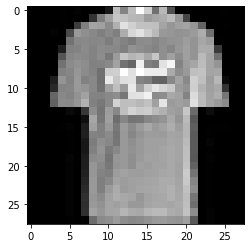

In [125]:
dataiter = iter(trainloader)
import matplotlib.pyplot as plt
import random
# .next() will return the next batch of data, great!
images, labels = dataiter.next()
# Here's the shape of a batch of images, 16 images with 1 colour, 28 pixels high by 28 pixels wide
images.shape
plt.imshow(images[random.randint(0,15)].numpy().squeeze(), cmap='Greys_r');

In [149]:
# Neural Network
# Input size: 784
# Hidden sizes: Some powers of 2, e.g. 16, 32
# Output size: 10

# Input Size -> Hidden layer size -> [Optional additional layers] -> Output size

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # self.num_hidden = 1 # Number of Fully connected hidden layers
        self.fc0 = nn.Linear(IMG_HEIGHT*IMG_WIDTH, 128)
        self.fc1 = nn.Linear(128,10)
        # self.relu = nn.ReLU() # Why use this?

    # def set_num_hidden(self, value):
    #     self.num_hidden = value

    def forward(self,x):
        x = x.view(x.shape[0],IMG_HEIGHT*IMG_WIDTH)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        # x = F.softmax(x, dim=1) # Not needed when using CrossEntropyLoss?
        
        return x

model = Network()
model



Network(
  (fc0): Linear(in_features=784, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

In [150]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Epoch:1
[1,  2000] loss: 0.423
[1,  1000] loss: 0.422
[1,  2000] loss: 0.842
[1,  3000] loss: 1.261
Epoch:2
[2,  2000] loss: 0.411
[2,  1000] loss: 0.407
[2,  2000] loss: 0.830
[2,  3000] loss: 1.237
Epoch:3
[3,  2000] loss: 0.412
[3,  1000] loss: 0.392
[3,  2000] loss: 0.798
[3,  3000] loss: 1.200


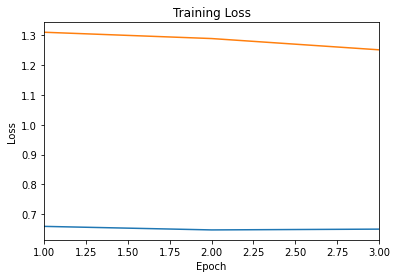

In [167]:
from torch.autograd import Variable

epochs = 3

epoch_values = []
loss_values = []
valid_loss_values = []
for e in range(epochs):
    print(f"Epoch:{e+1}")
    running_loss = 0.0
    running_valid_loss = 0

    for i, (inputs, labels) in enumerate(iter(trainloader)):
        output = model(inputs)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 2000))

    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(iter(validloader)):
            output = model(inputs)
            valid_loss = criterion(output, labels)
            running_valid_loss += valid_loss.item()

            if i % 1000 == 999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_valid_loss / 1000))

    epoch_values.append(e+1)    
    loss_values.append(running_loss/2000)
    valid_loss_values.append(running_valid_loss/1000)

plt.plot(epoch_values, loss_values)
plt.plot(epoch_values, valid_loss_values)
# plt.legend('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlim((1, epochs))
plt.show()
        

In [129]:
torch.save(model.state_dict(), 'model1.pt')

In [155]:
# model.eval()
# with torch.no_grad():
#     for i, (inputs, labels) in enumerate(iter(validloader)):
#         output = model(inputs)
#         valid_loss = criterion(output, labels)
    

In [143]:
F.softmax(output, dim=1)

torch.Size([16, 10])

In [145]:
output.shape

torch.Size([16, 10])

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
torch.Size([1, 28, 28])


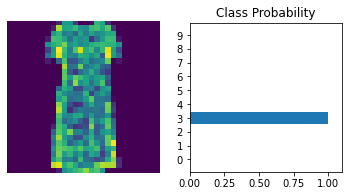

In [163]:
images, labels = iter(testloader).next()
img = images[0]
ps = F.softmax(model.forward(img)) # why this doesnt work same way without forward?
print(img.shape)
view_classify(img, ps)

In [164]:
ps.data.numpy().squeeze()

array([1.3880788e-04, 1.5697726e-05, 1.5170876e-10, 9.9983966e-01,
       1.4042446e-07, 1.0816978e-25, 5.6296917e-06, 0.0000000e+00,
       9.2173721e-08, 1.6666165e-30], dtype=float32)

In [117]:
with torch.no_grad():
    for i, (inputs, labels) in enumerate(iter(validloader)):
        output = model(inputs)
        = F.softmax(output)


3124

In [115]:
output.shape

torch.Size([16, 10])

In [110]:
list(model.named_parameters())[2]

('fc1.weight',
 Parameter containing:
 tensor([[-0.1018, -0.0330,  0.0230,  ...,  0.1138, -0.0151,  0.0459],
         [-0.0351, -0.0008, -0.1467,  ..., -0.1693, -0.0922,  0.0204],
         [-0.0069, -0.0827, -0.0416,  ...,  0.0058,  0.0337,  0.0679],
         ...,
         [ 0.0647, -0.0840, -0.0736,  ...,  0.0564,  0.0570,  0.0590],
         [ 0.0134, -0.0066, -0.0287,  ...,  0.0658, -0.0053,  0.1269],
         [-0.0033,  0.0549, -0.1309,  ..., -0.0648, -0.0892,  0.0040]],
        requires_grad=True))

In [ ]:
for _, (images,labels) in enumerate(iter(trainloade):
    print(images)
    print(labels)

TypeError: 'bool' object is not callable

|Label|Description|
---|---
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle boot|


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e82726f2-d633-41f1-a586-f5a97bd73737' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>